# Overview

A simple vanilla RNN implementation of a Shakespeare generator with pyTorch. The generator is trained character by character, using a single hidden layer unit. The result is mediocre, some parameter tweaking might make it perform better.

### Surprises


### Todo:
- [ ] play with hyper parameters

### Done:
- [x] Add temperature to generator
- [x] get training to work
- [x] use optim and Adam
- [x] add self-feeding generator

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, num_flat_features

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output

In [2]:
source = "";
with open('./data/shakespeare.txt', 'r') as f:
    for line in f:
        source += line + "\n"
        
source +=" " * 606
print([source[:60]])
len(source)

['First Citizen:\n\nBefore we proceed any further, hear me speak']


1156000

In [3]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.xhh = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.ho = torch.nn.Linear(hidden_size, output_size)
        self.softmax = F.softmax
        
    def forward(self, x, hidden):
        xs = x.chunk(x.size()[0])
        outputs = []
        for row_vec in xs:
            hidden = self.xhh(torch.cat((row_vec, hidden), 1))
            outputs.append(self.ho(hidden))
        output = torch.cat(outputs, 0)
        return output, hidden
    
    def init_hidden(self, random=False):
        if random:
            return Variable(torch.randn(1, self.hidden_size))
        else:
            return Variable(torch.zeros(1, self.hidden_size)) 
"""                                     
rnn = VanillaRNN(100, 120, 90)
hidden = rnn.init_hidden()
rnn(Variable(torch.randn(1, 100)), hidden, 10)"""

'                                     \nrnn = VanillaRNN(100, 120, 90)\nhidden = rnn.init_hidden()\nrnn(Variable(torch.randn(1, 100)), hidden, 10)'

In [4]:
class Shakespeare():
    def __init__(self, model):
        self.model = model
        self.char2vec = Char2Vec()
        self.loss = 0
        self.losses = []
    
    def init_hidden_(self, random=False):
        self.hidden = model.init_hidden(random)
        return self
    
    def save(self, fn="Vanilla_RNN_Shakespeare.tar"):
        torch.save({
            "hidden": self.hidden, 
            "state_dict": model.state_dict(),
            "losses": self.losses
                   }, fn)
    
    def load(self, fn):
        checkpoint = torch.load(fn)
        self.hidden = checkpoint['hidden']
        model.load_state_dict(checkpoint['state_dict'])
        self.losses = checkpoint['losses']
    
    def setup_training(self, learning_rate):
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_hidden_()
        
    def reset_loss(self):
        self.loss = 0
        
    def forward(self, input_text, target_text):
        
        self.hidden.detach_()
        self.optimizer.zero_grad()
        self.next_(input_text)
        target_vec = Variable(self.char2vec.char_code(target_text))
        self.loss += self.loss_fn(self.output, target_vec)
        
    def descent(self):
        self.loss.backward()
        self.optimizer.step()
        self.losses.append(self.loss.cpu().data.numpy())
        self.reset_loss()
    
    def embed(self, input_data):
        self.embeded = Variable(self.char2vec.one_hot(input_data))
        return self.embeded
        
    def next_(self, input_text):
        self.output, self.hidden = self.model(
            self.embed(input_text)#.view(1, -1, self.model.input_size)
            , self.hidden)
        return self
    
    def softmax_(self, temperature=0.5):
        self.softmax = self.model.softmax(self.output/temperature)
        return self
    
    def text(self, start=None, end=None):
        indeces = torch.multinomial(self.softmax[start:end]).view(-1)
        return self.char2vec.vec2str(indeces)

In [5]:
input_size = 100 # len(char2vec.chars)
hidden_size = input_size

model = VanillaRNN(input_size, hidden_size, input_size)
william = Shakespeare(model)
# william.load('./data/Vanilla_RNN_Shakespeare.tar')

In [10]:
learning_rate = 0.2e-4
william.setup_training(learning_rate)

Epoch 69


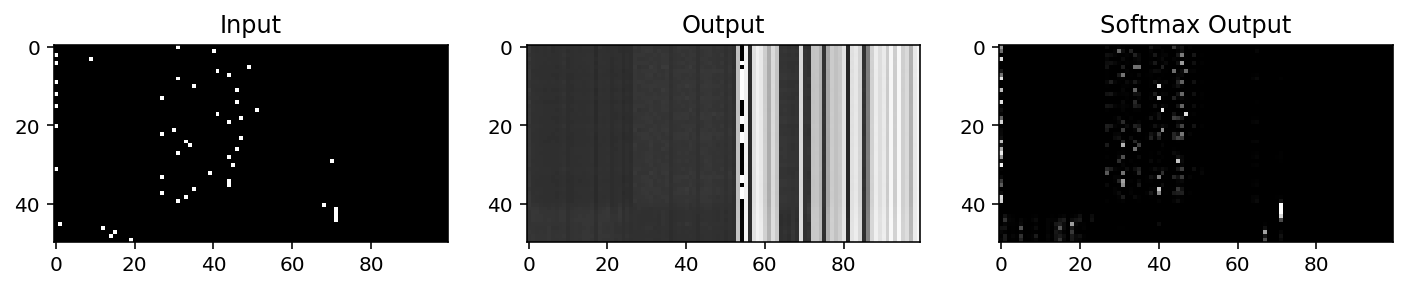

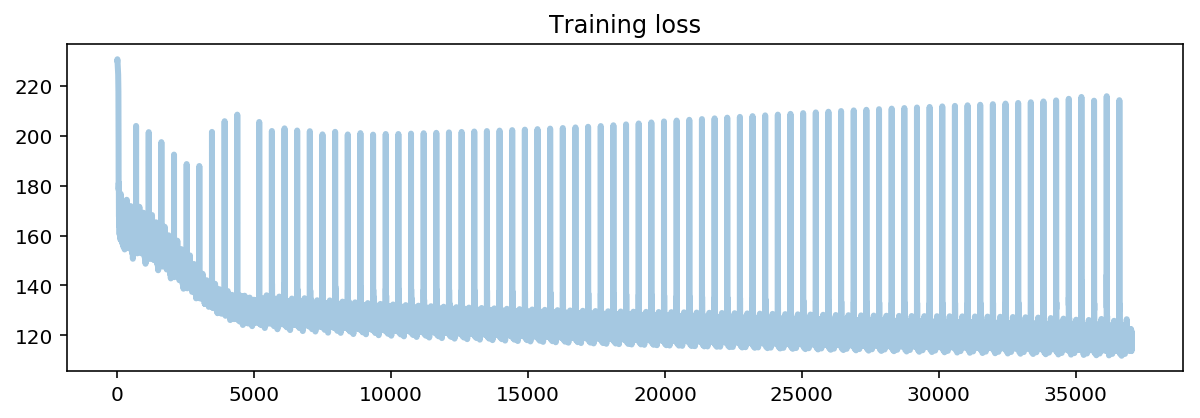

100%|█████████▉| 23037/23120 [02:34<00:01, 80.41it/s] 

  t th e tnhtn touv bots e   s tese nn n



SRRRL:


100%|██████████| 23120/23120 [02:34<00:00, 149.45it/s]


In [11]:
model.zero_grad()
william.reset_loss()

seq_length = 50
batches = int(len(source)/seq_length)

for epoch_num in range(70):
    
    for step in tqdm(range(batches)):

        source_ = source[step*seq_length:(step+1)*seq_length]
        
        william.forward(source_, source_[1:] + " ")
        #william.descent()
        
        if step%50 == 49:
            william.descent()
        
        if step%1000 == 999:
            clear_output(wait=True)
            print('Epoch {:d}'.format(epoch_num))

            william.softmax_()

            plt.figure(figsize=(12, 9))
            plt.subplot(131)
            plt.title("Input")
            plt.imshow(william.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(132)
            plt.title("Output")
            plt.imshow(william.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(133)
            plt.title("Softmax Output")
            plt.imshow(william.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
            plt.show()
            
            plt.figure(figsize=(10, 3))
            plt.title('Training loss')
            plt.plot(william.losses, label="loss", linewidth=3, alpha=0.4)
            plt.show()

            print(william.text(0,150))

## Now use the network to generate text!

In [12]:
william.save('./data/Vanilla_RNN_Shakespeare.tar')

In [13]:
from ipywidgets import widgets
from IPython.display import display

Frtodo.

wove?-mfht?.

IAzCharc!dWoou lo.'l;,

Veipaqugow;cthfhmis?ns!
oriloveve.;.

ouk-Rhou.

beareqhe?, tzinf.


Zoarchasecail?d coulll; folkexithll.
gfrer,;
yoh'dwtkend!

scyoukennseakvell..


SQ


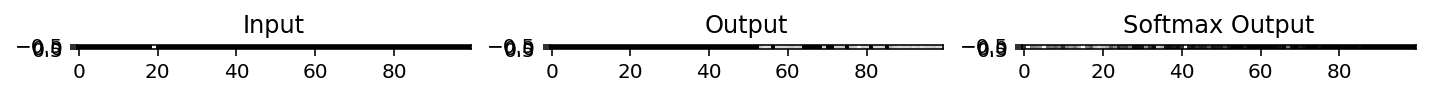

In [21]:
def predict_next(input_text, gen_length=None, temperature=0.05):
    
    if gen_length is None: 
        gen_length = len(input_text)
    
    clear_output(wait=True)
    william = Shakespeare(model).init_hidden_(random=True)
    
    william.next_(input_text)
    william.softmax_()
    string_output = william.text()
        
    for i in range(1, gen_length - len(input_text)):
        last_char = string_output[-1]
        william.next_(last_char)
        william.softmax_(temperature)
        string_output += william.text()
    
    print(string_output)
    
    plt.figure(figsize=(12, 9))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(william.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    plt.imshow(william.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(133)
    plt.title("Softmax Output")
    plt.imshow(william.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
    plt.show()

predict_next("Ge Yang:\n", 200, 1)

dce,hwovhmeegjoure..



Four.


Buringelave..



And averenge..



And there..



And, areare.



yourd.



Youthesther.;

Whare.



Wheres.


Whathere.



Wheres.


Whathererefoure.


Wherererering.



Whatheres.


Whatherestinge.




Thererour; beather.


Wherengherengor.



Whave thangere.




Sous are.



Whed merererere.




Shathengind.



There, fore, boure fore.



Singereathenganger.




Andereererereangeres pore.



Whe therereroure.



And bole, areangeres.



Thime mathere.



Southeresthere berengerengere;

here there.



Whe thereingere mere therengerengere.



Wherenghereres.




And oulle seres.



And foure the the beathe lase there houres ine there the the be thes and beathe coure ine the thethe patheng outhind and fous our be thengeather oure angese the there the that the the mend he seres and there be pore the 's be ther fore foure tous and his the the the there the theange the fither the thes and poure ther ino he the the mere the ther the the poure the the this a


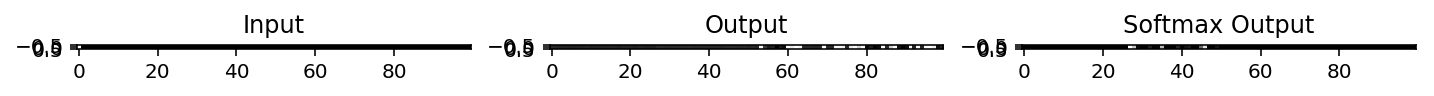

In [27]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    predict_next(text_input.value, 1000, temperature=0.25)
    
text_input.on_submit(handle_submit)

The prediction is okay...😅